# Youtube Data Analytics

## Problem Understanding

The YouTube8M challenge is a multi-label classification problem, where we are asked to predict one or more labels for each video, given video & frame level audio and frame RGB features, to which group of categories it belongs to.

Lets first explore the labels for the training data, their distribution and frequent patterns and co-occurance of the most frequent label categories.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## File descriptions

The training dataset contains videos and labels that are publicly available on YouTube.

- File descriptions

**video-level data**

Video-level features are stored as tensorflow.Example protocol buffers. The total size of the video-level features is 31 GB. They are broken into 3844 shards which can be subsampled to reduce the dataset size. 

Each video has
- id: unique id for the video, in train set it is a Youtube video id, and in test/validation they are anonymized
- labels: list of labels of that video
- mean_rgb: float array of length 1024
- mean_audio: float array of length 128

**frame-level data**

Frame-level features are stored as tensorflow.SequenceExample protocol buffers. The total size of the frame-level features is 1.53 TB. They are broken into 3844 shards which can be subsampled to reduce the dataset size.

Each video has
- id: unique id for the video, in train set it is a YouTube video id, and in test/validation they are anonymized.
- labels: list of labels of that video.
- Frames: Max number up to 300 frames.
    - Each frame has rgb: float array of length 1024,
    - Each frame has audio: float array of length 128


video_sample.zip - a sample of video-level data including train00 and train01 (<10 mb) 
frame_sample.zip - a sample of frame-level data including train00 and train01 (>500 mb)
label_names_2018.csv - a mapping between label_id and label_name (< 1 mb) 
vocabulary.csv - the full data dictionary for label names and their descriptions (3 mb)

From https://research.google.com/youtube8m/

**Hidden Video IDs**  
To protect the privacy of uploaders, Google does not use YouTube IDs as part of this dataset. Instead, they associate each video with a Randomly-generated ID, which they store under context feature with name "id". Nonetheless, developpers can lookup the external YouTube ID using the Randomly-generated one, as long as the video remains public on YouTube. When a video gets deleted, or made private by its uploader, the lookup URL becomes invalid.  


**Translating Video IDs**  
The ID field in the TensorFlow record files is a 4-character string (e.g. ABCD). To get the YouTubeID, one can construct a URL like /AB/ABCD.js (note: first 2 characters are repeated!), and append it to this [URL](data.yt8m.org/2/j/i). As a real example, the ID nXSc can be converted to a video ID via the [{URL}/nX/nXSc.js](data.yt8m.org/2/j/i/nX/nXSc.js). The format of the file is JSONP, and should be self-explainatory.


## Exploratory Data Analysis

Let's first explore labels and their distributions

In [2]:
# total number of labels
labels_df = pd.read_csv('label_names_2018.csv', usecols=['label_id', 'label_name'])
labels_df.head()

,label_id,label_name
0,0,Game
1,1,Video game
2,2,Vehicle
3,3,Concert
4,4,Musician


In [3]:
print("Total numbers of labels in sample dataset: {} ".format(labels_df['label_name'].nunique()))

Total numbers of labels in sample dataset: 3861 


In [4]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862 entries, 0 to 3861
Data columns (total 2 columns):
label_id      3862 non-null int64
label_name    3862 non-null object
dtypes: int64(1), object(1)
memory usage: 60.4+ KB


In [5]:
# Read the vocabulary file.
vocab_df = pd.read_csv('vocabulary.csv')
vocab_df.head()

,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
0,0,788288,/m/03bt1gh,Game,https://en.wikipedia.org/wiki/Game,Games,NaN,NaN,"A game is structured form of play, usually und..."
1,1,539945,/m/01mw1,Video game,https://en.wikipedia.org/wiki/Video_game,Games,NaN,NaN,A video game is an electronic game that involv...
2,2,415890,/m/07yv9,Vehicle,https://en.wikipedia.org/wiki/Vehicle,Autos & Vehicles,NaN,NaN,A vehicle is a mobile machine that transports ...
3,3,378135,/m/01jddz,Concert,https://en.wikipedia.org/wiki/Concert,Arts & Entertainment,NaN,NaN,A concert is a live music performance in front...
4,4,286532,/m/09jwl,Musician,https://en.wikipedia.org/wiki/Musician,Arts & Entertainment,NaN,NaN,A musician is a person who plays a musical ins...


In [6]:
vocab_df.describe()

,Index,TrainVideoCount
count,3862.000000,3862.000000
mean,1930.500000,3032.527188
std,1115.007698,21182.048375
min,0.000000,123.000000
25%,965.250000,234.000000
50%,1930.500000,440.500000
75%,2895.750000,1199.750000
max,3861.000000,788288.000000


In [7]:
vocab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862 entries, 0 to 3861
Data columns (total 9 columns):
Index               3862 non-null int64
TrainVideoCount     3862 non-null int64
KnowledgeGraphId    3862 non-null object
Name                3806 non-null object
WikiUrl             3806 non-null object
Vertical1           3862 non-null object
Vertical2           584 non-null object
Vertical3           32 non-null object
WikiDescription     3806 non-null object
dtypes: int64(2), object(7)
memory usage: 271.6+ KB


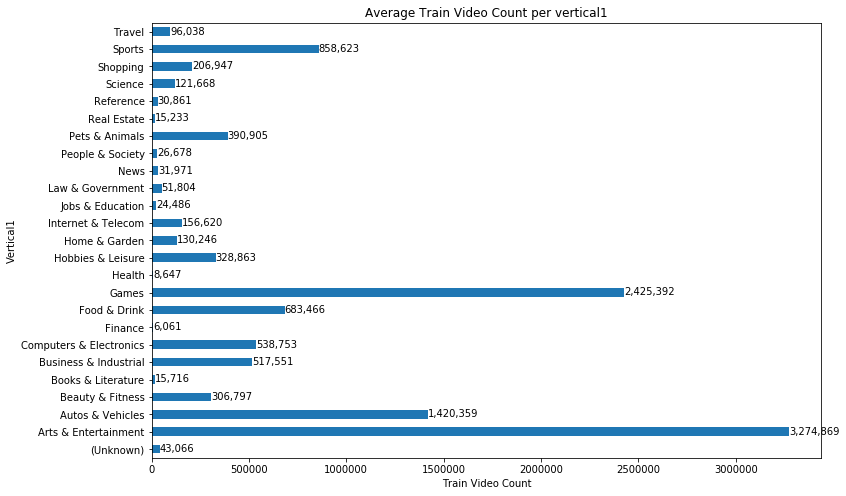

In [8]:
plt.figure(figsize = (12,8))
vertical1 = vocab_df.groupby('Vertical1').TrainVideoCount.sum()
vertical1.plot(kind="barh")
# annotate value labels
for index, value in enumerate(vertical1): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(value, index - 0.15), color='black')
plt.title("Average Train Video Count per vertical1")
plt.xlabel('Train Video Count')
plt.show()

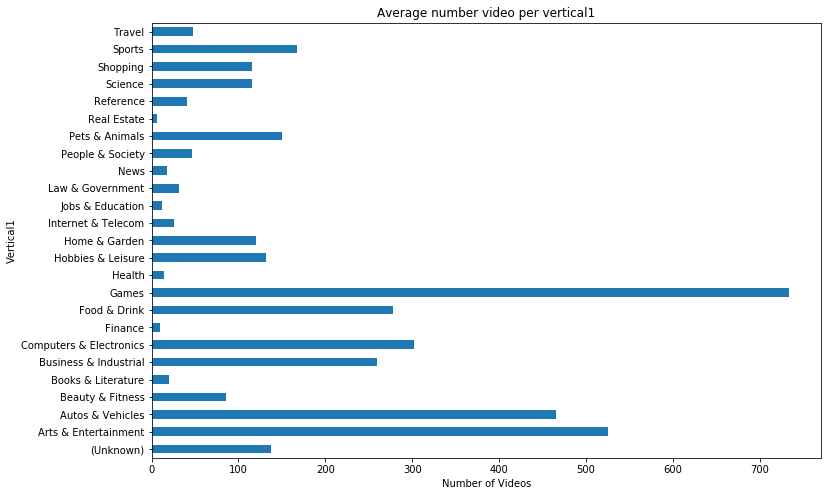

In [9]:
plt.figure(figsize = (12,8))
vocab_df.groupby('Vertical1').Index.count().plot(kind="barh")
plt.title("Average number video per vertical1")
plt.xlabel('Number of Videos')
plt.show()

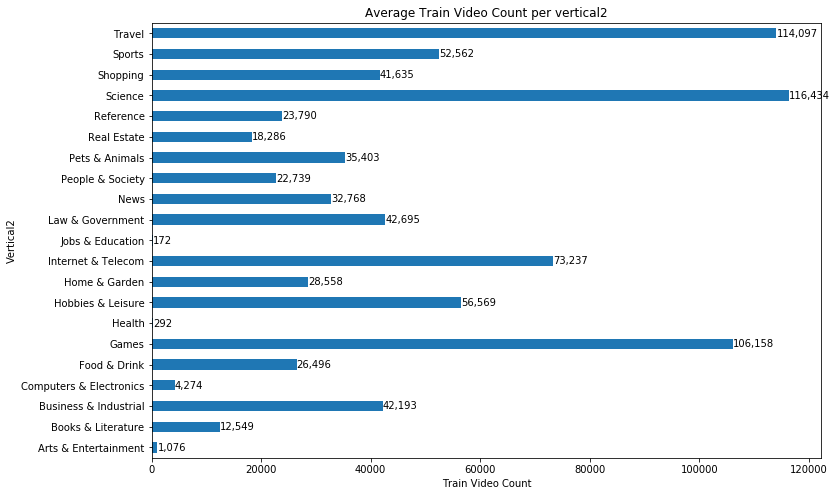

In [10]:
plt.figure(figsize = (12,8))
vertical2 = vocab_df.groupby('Vertical2').TrainVideoCount.sum()
vertical2.plot(kind="barh")
# annotate value labels
for index, value in enumerate(vertical2): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(value, index - 0.15), color='black')
plt.title("Average Train Video Count per vertical2")
plt.xlabel('Train Video Count')
plt.show()

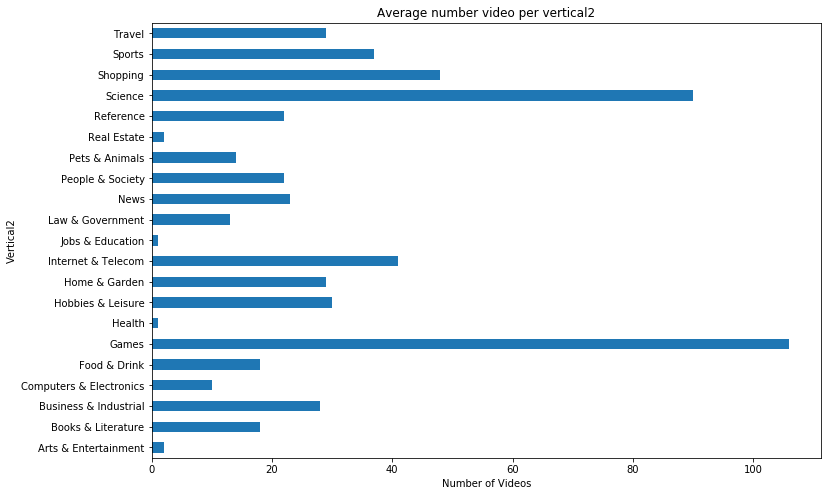

In [11]:
plt.figure(figsize = (12,8))
vocab_df.groupby('Vertical2').Index.count().plot(kind="barh")
plt.title("Average number video per vertical2")
plt.xlabel('Number of Videos')
plt.show()

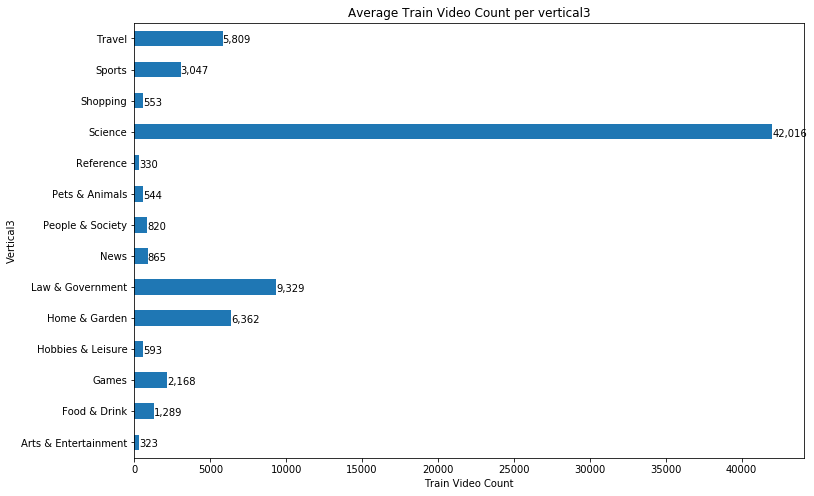

In [12]:
plt.figure(figsize = (12,8))
vertical3 = vocab_df.groupby('Vertical3').TrainVideoCount.sum()
vertical3.plot(kind="barh")
# annotate value labels
for index, value in enumerate(vertical3): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(value, index - 0.15), color='black')
plt.title("Average Train Video Count per vertical3")
plt.xlabel('Train Video Count')
plt.show()

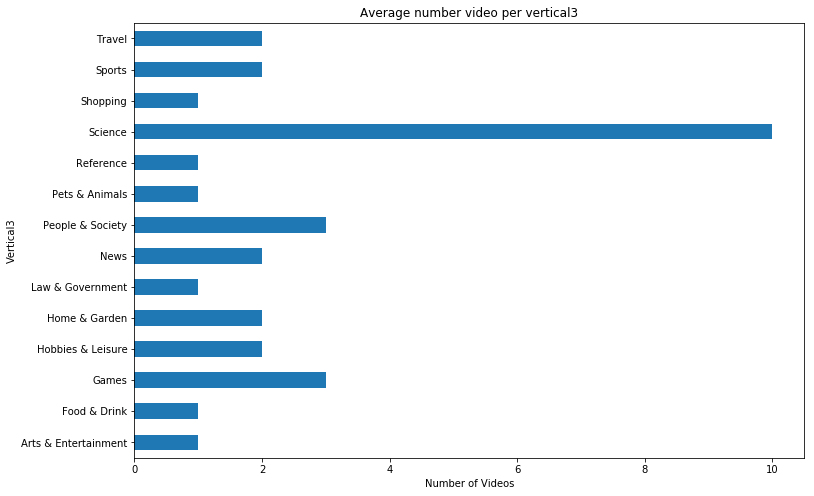

In [13]:
plt.figure(figsize = (12,8))
vocab_df.groupby('Vertical3').Index.count().plot(kind="barh")
plt.title("Average number video per vertical3")
plt.xlabel('Number of Videos')
plt.show()